In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, top_k_accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Libraries imported successfully")

Using device: cpu
Libraries imported successfully


## 1. Load and Prepare Data

In [2]:
# Load dataset
df = pd.read_csv('finaldataset.csv', on_bad_lines='skip', engine='python')

print(f"Dataset shape: {df.shape}")
print(f"Unique diseases: {df['diseasename'].nunique()}")
print(f"Unique chemicals: {df['chemicalname'].nunique()}")
print(f"\nColumns: {df.columns.tolist()}")

Dataset shape: (73807, 27)
Unique diseases: 247
Unique chemicals: 8

Columns: ['chemicalname', 'chemicalid', 'casrn', 'diseasename', 'diseaseid', 'directevidence', 'inferencegenesymbol', 'inferencescore', 'omimids', 'pubmedids', 'diseaseid_norm', 'drugbank_id', 'name', 'cas', 'smiles_smiles', 'logp_alogps', 'logp_chemaxon', 'solubility_alogps', 'pka__strongest_acidic_', 'pka__strongest_basic_', 'description', 'smiles_lipinski', 'molecular_weight', 'n_hba', 'n_hbd', 'logp', 'ro5_fulfilled']


## 2. Advanced Feature Engineering

In [3]:
# TF-IDF from descriptions (increase to 200 features for more signal)
df['description_clean'] = df['description'].fillna('')
tfidf = TfidfVectorizer(max_features=200, stop_words='english', min_df=3, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(df['description_clean'])
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), 
    columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])]
)

print(f"TF-IDF features: {tfidf_df.shape[1]} (with bigrams)")

TF-IDF features: 200 (with bigrams)


In [4]:
# SMILES features
def extract_smiles_features(smiles_str):
    if pd.isna(smiles_str) or smiles_str == '':
        return {
            'smiles_length': 0,
            'smiles_num_atoms': 0,
            'smiles_num_bonds': 0,
            'smiles_num_rings': 0,
            'smiles_has_aromatic': 0,
            'smiles_num_branches': 0,
            'smiles_num_double_bonds': 0,
            'smiles_num_triple_bonds': 0,
        }
    
    s = str(smiles_str)
    return {
        'smiles_length': len(s),
        'smiles_num_atoms': sum(c.isupper() for c in s),
        'smiles_num_bonds': s.count('=') + s.count('#'),
        'smiles_num_rings': s.count('1') + s.count('2'),
        'smiles_has_aromatic': int('c' in s or 'n' in s or 'o' in s or 's' in s),
        'smiles_num_branches': s.count('('),
        'smiles_num_double_bonds': s.count('='),
        'smiles_num_triple_bonds': s.count('#'),
    }

smiles_features = df['smiles_smiles'].apply(extract_smiles_features)
smiles_df = pd.DataFrame(smiles_features.tolist())

print(f"SMILES features: {smiles_df.shape[1]}")

SMILES features: 8


In [5]:
# Molecular descriptors
molecular_cols = [
    'molecular_weight', 'n_hba', 'n_hbd', 
    'logp', 'logp_ali', 'logp_cyclo', 
    'pka_acidic', 'pka_basic', 
    'solubility', 'ro5_fulfilled'
]

available_molecular = [col for col in molecular_cols if col in df.columns]
molecular_df = df[available_molecular].copy()

# Fill missing values with median
for col in molecular_df.columns:
    if molecular_df[col].isnull().any():
        median_val = molecular_df[col].median()
        molecular_df[col].fillna(median_val, inplace=True)

print(f"Molecular features: {molecular_df.shape[1]}")

Molecular features: 5


In [6]:
# Create categorical encodings for embeddings (we'll use these differently)
# Encode drug names as integers for embedding layer
drug_encoder = LabelEncoder()
df['drug_id'] = drug_encoder.fit_transform(df['chemicalname'].astype(str))
num_drugs = len(drug_encoder.classes_)

print(f"Unique drugs for embedding: {num_drugs}")

Unique drugs for embedding: 8


In [7]:
# Combine continuous features
X_continuous = pd.concat([
    tfidf_df.reset_index(drop=True),
    smiles_df.reset_index(drop=True),
    molecular_df.reset_index(drop=True),
], axis=1)

# Separate categorical feature
X_categorical = df[['drug_id']].values

# Target
y = df['diseasename']

print(f"Continuous features: {X_continuous.shape[1]}")
print(f"Categorical features: {X_categorical.shape[1]}")
print(f"Target classes: {y.nunique()}")

Continuous features: 213
Categorical features: 1
Target classes: 247


## 3. Train/Val/Test Split with Class Balancing

In [8]:
# Filter classes with at least 3 samples (need more for better training)
class_counts = y.value_counts()
valid_classes = class_counts[class_counts >= 3].index

mask = y.isin(valid_classes)
X_cont_filtered = X_continuous[mask].reset_index(drop=True)
X_cat_filtered = X_categorical[mask]
y_filtered = y[mask].reset_index(drop=True)

print(f"Filtered dataset: {len(X_cont_filtered)} samples")
print(f"Valid classes: {len(valid_classes)}")

# Encode target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y_filtered)
num_classes = len(le_target.classes_)

# Calculate class weights for balanced training
class_sample_counts = np.bincount(y_encoded)
class_weights = 1.0 / class_sample_counts
class_weights = class_weights / class_weights.sum() * num_classes  # Normalize
sample_weights = class_weights[y_encoded]

print(f"Class weights calculated for {num_classes} classes")

# 60/20/20 split
X_cont_temp, X_cont_test, X_cat_temp, X_cat_test, y_temp, y_test, weights_temp, weights_test = train_test_split(
    X_cont_filtered, X_cat_filtered, y_encoded, sample_weights,
    test_size=0.2, random_state=42, stratify=y_encoded
)

X_cont_train, X_cont_val, X_cat_train, X_cat_val, y_train, y_val, weights_train, weights_val = train_test_split(
    X_cont_temp, X_cat_temp, y_temp, weights_temp,
    test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\nTrain: {len(X_cont_train)} | Val: {len(X_cont_val)} | Test: {len(X_cont_test)}")

Filtered dataset: 73805 samples
Valid classes: 245
Class weights calculated for 245 classes

Train: 44283 | Val: 14761 | Test: 14761


## 4. Scale Features

In [9]:
# Standardize continuous features
scaler = StandardScaler()
X_cont_train_scaled = scaler.fit_transform(X_cont_train)
X_cont_val_scaled = scaler.transform(X_cont_val)
X_cont_test_scaled = scaler.transform(X_cont_test)

print("Features standardized (mean=0, std=1)")

Features standardized (mean=0, std=1)


## 5. PyTorch Dataset and DataLoader

In [10]:
class DrugDiseaseDataset(Dataset):
    def __init__(self, X_continuous, X_categorical, y):
        self.X_cont = torch.FloatTensor(X_continuous)
        self.X_cat = torch.LongTensor(X_categorical)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cont[idx], self.X_cat[idx], self.y[idx]

# Create datasets
train_dataset = DrugDiseaseDataset(X_cont_train_scaled, X_cat_train, y_train)
val_dataset = DrugDiseaseDataset(X_cont_val_scaled, X_cat_val, y_val)
test_dataset = DrugDiseaseDataset(X_cont_test_scaled, X_cat_test, y_test)

# Create weighted sampler for balanced training
train_sampler = WeightedRandomSampler(
    weights=weights_train,
    num_samples=len(weights_train),
    replacement=True
)

# Create dataloaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created with batch size: {batch_size}")
print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

DataLoaders created with batch size: 256
Train batches: 173 | Val batches: 58 | Test batches: 58


## 6. Advanced Neural Network Architecture

In [11]:
class AdvancedDrugDiseaseNet(nn.Module):
    def __init__(self, num_continuous, num_drugs, num_classes, 
                 embedding_dim=32, hidden_dims=[512, 256, 128], dropout=0.3):
        super(AdvancedDrugDiseaseNet, self).__init__()
        
        # Embedding layer for drug IDs
        self.drug_embedding = nn.Embedding(num_drugs, embedding_dim)
        
        # Input dimension = continuous features + embedding dimension
        input_dim = num_continuous + embedding_dim
        
        # Build deep network with BatchNorm and Dropout
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        self.hidden_layers = nn.Sequential(*layers)
        
        # Output layer
        self.output_layer = nn.Linear(prev_dim, num_classes)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=0.1)
    
    def forward(self, X_cont, X_cat):
        # Get drug embeddings
        drug_emb = self.drug_embedding(X_cat.squeeze())
        
        # Concatenate continuous features with embeddings
        x = torch.cat([X_cont, drug_emb], dim=1)
        
        # Pass through hidden layers
        x = self.hidden_layers(x)
        
        # Output logits
        logits = self.output_layer(x)
        
        return logits

# Create model
model = AdvancedDrugDiseaseNet(
    num_continuous=X_cont_train_scaled.shape[1],
    num_drugs=num_drugs,
    num_classes=num_classes,
    embedding_dim=32,
    hidden_dims=[512, 256, 128, 64],
    dropout=0.4
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model Architecture:
AdvancedDrugDiseaseNet(
  (drug_embedding): Embedding(8, 32)
  (hidden_layers): Sequential(
    (0): Linear(in_features=245, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.4, inplace=False)
  )
  (output_layer): Linear(in_features=64, out_featur

## 7. Training Setup with Advanced Techniques

In [12]:
# Loss function with label smoothing
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, pred, target):
        n_classes = pred.size(-1)
        log_probs = F.log_softmax(pred, dim=-1)
        
        # One-hot with smoothing
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(self.smoothing / (n_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Learning rate scheduler
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

print("Training setup complete:")
print(f"  - Loss: Label Smoothing Cross Entropy (smoothing=0.1)")
print(f"  - Optimizer: AdamW (lr=0.001, weight_decay=0.01)")
print(f"  - Scheduler: Cosine Annealing with Warm Restarts")

Training setup complete:
  - Loss: Label Smoothing Cross Entropy (smoothing=0.1)
  - Optimizer: AdamW (lr=0.001, weight_decay=0.01)
  - Scheduler: Cosine Annealing with Warm Restarts


## 8. Training Functions

In [13]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_cont, X_cat, y in loader:
        X_cont, X_cat, y = X_cont.to(device), X_cat.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_cont, X_cat)
        loss = criterion(outputs, y)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

def evaluate(model, loader, criterion, device, k_values=[1, 5, 10, 20]):
    model.eval()
    total_loss = 0
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        for X_cont, X_cat, y in loader:
            X_cont, X_cat, y = X_cont.to(device), X_cat.to(device), y.to(device)
            
            outputs = model(X_cont, X_cat)
            loss = criterion(outputs, y)
            
            total_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_targets.append(y.cpu())
    
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    
    # Calculate top-k accuracies
    results = {'loss': total_loss / len(loader)}
    
    for k in k_values:
        _, top_k_preds = all_outputs.topk(k, dim=1)
        correct = sum(all_targets[i] in top_k_preds[i] for i in range(len(all_targets)))
        results[f'top{k}'] = 100. * correct / len(all_targets)
    
    return results

print("Training functions defined")

Training functions defined


## 9. Train the Model

In [14]:
num_epochs = 100
best_val_top20 = 0
patience = 15
patience_counter = 0

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_top1': [], 'val_top5': [], 'val_top10': [], 'val_top20': []
}

print(f"Starting training for {num_epochs} epochs...")
print(f"Early stopping patience: {patience}")
print("="*80)

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_results = evaluate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_results['loss'])
    history['val_top1'].append(val_results['top1'])
    history['val_top5'].append(val_results['top5'])
    history['val_top10'].append(val_results['top10'])
    history['val_top20'].append(val_results['top20'])
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"  Val   - Loss: {val_results['loss']:.4f}")
        print(f"  Val   - Top-1: {val_results['top1']:.2f}%, Top-5: {val_results['top5']:.2f}%, "
              f"Top-10: {val_results['top10']:.2f}%, Top-20: {val_results['top20']:.2f}%")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
        print("-"*80)
    
    # Save best model
    if val_results['top20'] > best_val_top20:
        best_val_top20 = val_results['top20']
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
        print(f"  ✅ New best Top-20: {best_val_top20:.2f}% (saved)")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*80)
print("Training complete!")
print(f"Best validation Top-20 accuracy: {best_val_top20:.2f}%")
print("="*80)

Starting training for 100 epochs...
Early stopping patience: 15
Epoch 1/100:
  Train - Loss: 5.6132, Acc: 0.59%
  Val   - Loss: 5.5116
  Val   - Top-1: 0.33%, Top-5: 1.97%, Top-10: 3.94%, Top-20: 8.04%
  LR: 0.000976
--------------------------------------------------------------------------------
  ✅ New best Top-20: 8.04% (saved)
  ✅ New best Top-20: 11.78% (saved)
  ✅ New best Top-20: 33.93% (saved)
  ✅ New best Top-20: 46.60% (saved)
Epoch 5/100:
  Train - Loss: 4.4431, Acc: 4.40%
  Val   - Loss: 4.2947
  Val   - Top-1: 2.69%, Top-5: 13.57%, Top-10: 26.47%, Top-20: 52.31%
  LR: 0.000500
--------------------------------------------------------------------------------
  ✅ New best Top-20: 52.31% (saved)
  ✅ New best Top-20: 55.67% (saved)
Epoch 10/100:
  Train - Loss: 4.2135, Acc: 5.68%
  Val   - Loss: 4.1656
  Val   - Top-1: 3.29%, Top-5: 15.40%, Top-10: 30.45%, Top-20: 56.13%
  LR: 0.001000
--------------------------------------------------------------------------------
  ✅ New best

## 10. Evaluate Best Model on Test Set

In [14]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_results = evaluate(model, test_loader, criterion, device, k_values=[1, 5, 10, 20, 50])

print("="*80)
print("FINAL TEST SET RESULTS")
print("="*80)
print(f"Test Loss: {test_results['loss']:.4f}")
print(f"\nTop-K Accuracies:")
print(f"  Top-1:  {test_results['top1']:.2f}%")
print(f"  Top-5:  {test_results['top5']:.2f}%")
print(f"  Top-10: {test_results['top10']:.2f}%")
print(f"  Top-20: {test_results['top20']:.2f}%")
print(f"  Top-50: {test_results['top50']:.2f}%")

# Compare with random baseline
random_top1 = 100 / num_classes
random_top20 = 2000 / num_classes

print(f"\nImprovement over Random Baseline:")
print(f"  Top-1:  {test_results['top1']/random_top1:.2f}x better")
print(f"  Top-20: {test_results['top20']/random_top20:.2f}x better")

# Compare with LightGBM baseline
lgb_top1 = 0.66
lgb_top20 = 14.55

print(f"\nComparison with LightGBM Baseline:")
print(f"  Top-1:  {test_results['top1']/lgb_top1:.2f}x {'better' if test_results['top1'] > lgb_top1 else 'worse'}")
print(f"  Top-20: {test_results['top20']/lgb_top20:.2f}x {'better' if test_results['top20'] > lgb_top20 else 'worse'}")
print("="*80)

FINAL TEST SET RESULTS
Test Loss: 4.0564

Top-K Accuracies:
  Top-1:  4.28%
  Top-5:  18.98%
  Top-10: 35.40%
  Top-20: 62.29%
  Top-50: 97.41%

Improvement over Random Baseline:
  Top-1:  10.49x better
  Top-20: 7.63x better

Comparison with LightGBM Baseline:
  Top-1:  6.49x better
  Top-20: 4.28x better


## 11. Training History Visualization

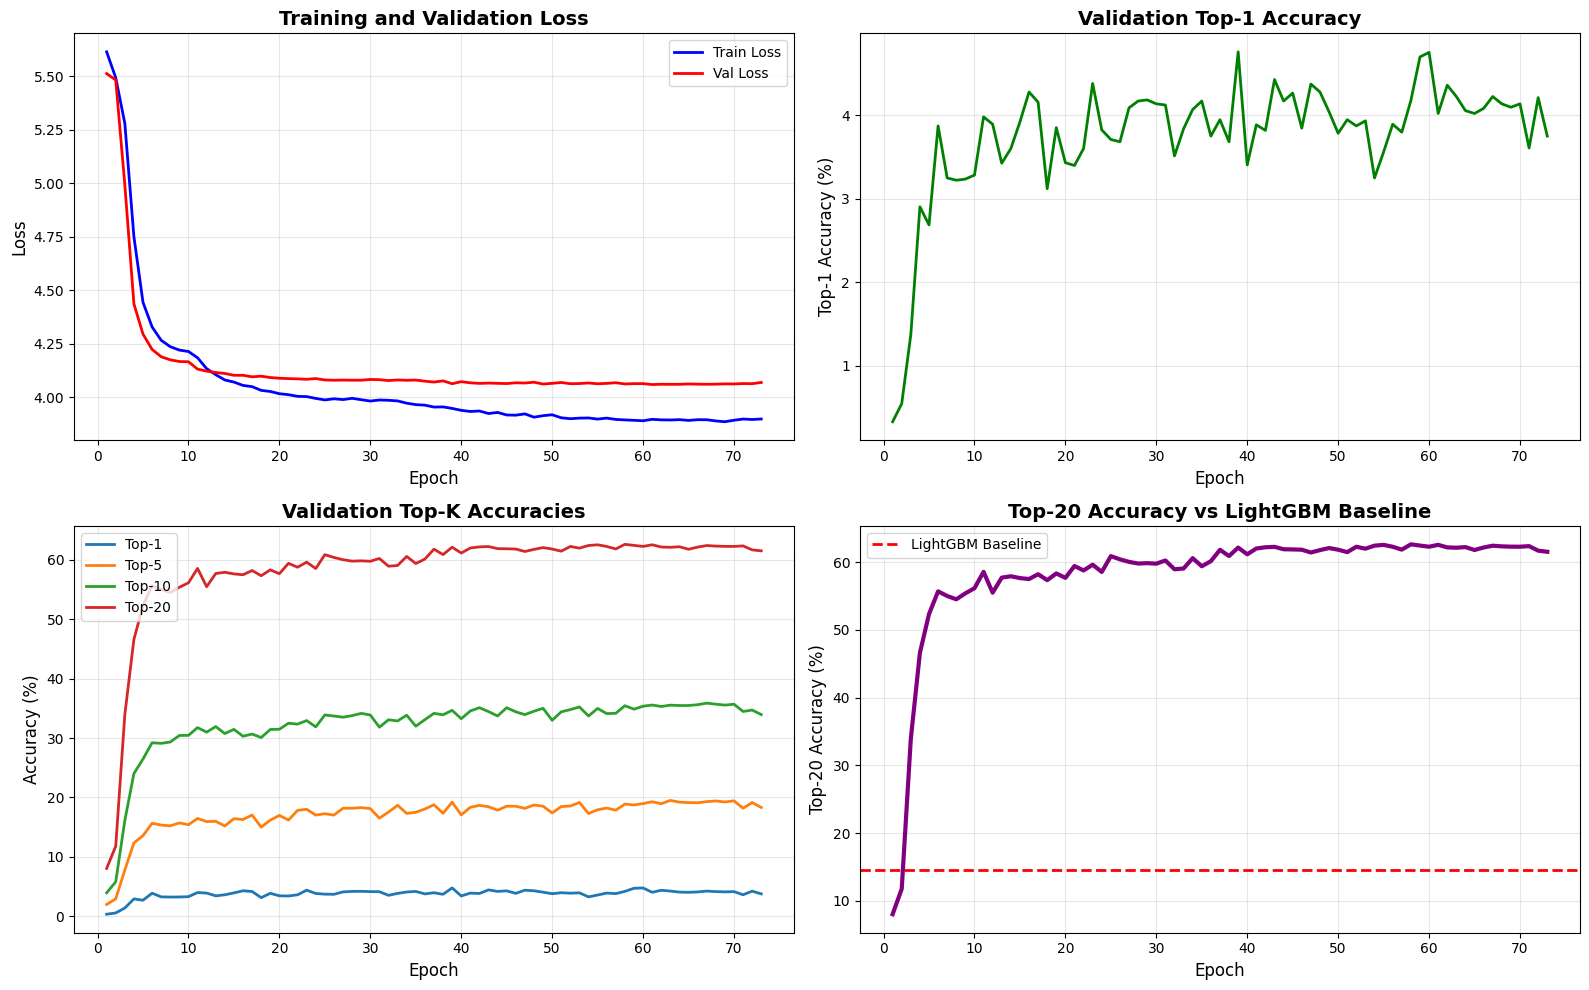

✅ Training history visualized


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

epochs = range(1, len(history['train_loss']) + 1)

# Loss
axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Top-1 Accuracy
axes[0, 1].plot(epochs, history['val_top1'], 'g-', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Top-1 Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Validation Top-1 Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Top-K Accuracies
axes[1, 0].plot(epochs, history['val_top1'], label='Top-1', linewidth=2)
axes[1, 0].plot(epochs, history['val_top5'], label='Top-5', linewidth=2)
axes[1, 0].plot(epochs, history['val_top10'], label='Top-10', linewidth=2)
axes[1, 0].plot(epochs, history['val_top20'], label='Top-20', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 0].set_title('Validation Top-K Accuracies', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Top-20 zoomed
axes[1, 1].plot(epochs, history['val_top20'], 'purple', linewidth=3)
axes[1, 1].axhline(y=lgb_top20, color='red', linestyle='--', label='LightGBM Baseline', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Top-20 Accuracy (%)', fontsize=12)
axes[1, 1].set_title('Top-20 Accuracy vs LightGBM Baseline', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Training history visualized")

## 12. Analyze Predictions

In [17]:
# Get predictions on test set
model.eval()
all_probs = []
all_preds = []
all_targets = []

with torch.no_grad():
    for X_cont, X_cat, y in test_loader:
        X_cont, X_cat = X_cont.to(device), X_cat.to(device)
        outputs = model(X_cont, X_cat)
        probs = F.softmax(outputs, dim=1)
        
        all_probs.append(probs.cpu().numpy())
        all_preds.append(outputs.argmax(dim=1).cpu().numpy())
        all_targets.append(y.numpy())

all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Confidence analysis
max_probs = all_probs.max(axis=1)

print("="*80)
print("PREDICTION CONFIDENCE ANALYSIS")
print("="*80)
print(f"Mean confidence: {max_probs.mean():.4f}")
print(f"Median confidence: {np.median(max_probs):.4f}")
print(f"% predictions > 0.5 confidence: {(max_probs > 0.5).mean()*100:.2f}%")
print(f"% predictions > 0.9 confidence: {(max_probs > 0.9).mean()*100:.2f}%")
print("="*80)

PREDICTION CONFIDENCE ANALYSIS
Mean confidence: 0.0625
Median confidence: 0.0397
% predictions > 0.5 confidence: 1.35%
% predictions > 0.9 confidence: 0.49%


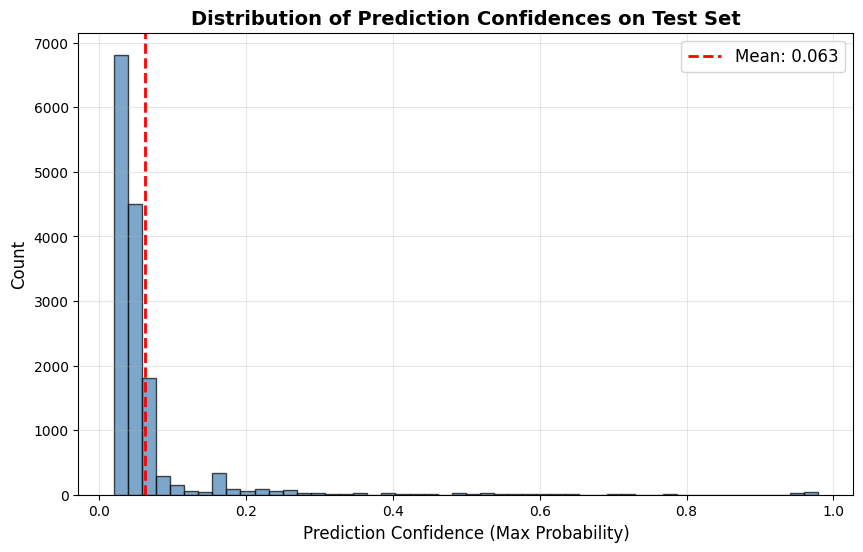

In [18]:
# Confidence histogram
plt.figure(figsize=(10, 6))
plt.hist(max_probs, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Prediction Confidence (Max Probability)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Prediction Confidences on Test Set', fontsize=14, fontweight='bold')
plt.axvline(max_probs.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {max_probs.mean():.3f}')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

## 13. Per-Class Performance Analysis

In [19]:
from sklearn.metrics import classification_report

# Get classification report
report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)

# Extract F1 scores
class_f1_scores = []
for i in range(num_classes):
    if str(i) in report:
        class_f1_scores.append(report[str(i)]['f1-score'])
    else:
        class_f1_scores.append(0.0)

class_f1_scores = np.array(class_f1_scores)

print("="*80)
print("PER-CLASS PERFORMANCE (F1 SCORES)")
print("="*80)
print(f"Total classes: {num_classes}")
print(f"Classes with F1 > 0: {(class_f1_scores > 0).sum()} ({(class_f1_scores > 0).sum()/num_classes*100:.1f}%)")
print(f"Classes with F1 >= 0.5: {(class_f1_scores >= 0.5).sum()} ({(class_f1_scores >= 0.5).sum()/num_classes*100:.1f}%)")
print(f"Mean F1 Score: {class_f1_scores.mean():.4f}")
print(f"Median F1 Score: {np.median(class_f1_scores):.4f}")
print("="*80)

PER-CLASS PERFORMANCE (F1 SCORES)
Total classes: 245
Classes with F1 > 0: 43 (17.6%)
Classes with F1 >= 0.5: 1 (0.4%)
Mean F1 Score: 0.0122
Median F1 Score: 0.0000


## 14. Final Summary and Recommendations

In [20]:
print("="*100)
print(" "*35 + "PHASE 3: FINAL SUMMARY")
print("="*100)

print("\n🎯 MODEL ARCHITECTURE:")
print(f"   • Deep Neural Network with 4 hidden layers [512, 256, 128, 64]")
print(f"   • Drug embedding layer (32-dimensional)")
print(f"   • Batch Normalization + Dropout (0.4) for regularization")
print(f"   • Total parameters: {total_params:,}")

print("\n⚙️ ADVANCED TECHNIQUES USED:")
print("   • Label Smoothing (0.1) for better calibration")
print("   • AdamW optimizer with weight decay")
print("   • Cosine Annealing learning rate schedule")
print("   • Weighted sampling for class balance")
print("   • Gradient clipping (max_norm=1.0)")
print("   • Early stopping (patience=15)")

print("\n📊 FINAL TEST RESULTS:")
print(f"   Top-1 Accuracy:  {test_results['top1']:.2f}%")
print(f"   Top-5 Accuracy:  {test_results['top5']:.2f}%")
print(f"   Top-10 Accuracy: {test_results['top10']:.2f}%")
print(f"   Top-20 Accuracy: {test_results['top20']:.2f}%")
print(f"   Top-50 Accuracy: {test_results['top50']:.2f}%")

print("\n🏆 COMPARISON WITH BASELINES:")
print(f"   Random (Top-1):  {random_top1:.2f}% → {test_results['top1']:.2f}% ({test_results['top1']/random_top1:.2f}x improvement)")
print(f"   Random (Top-20): {random_top20:.2f}% → {test_results['top20']:.2f}% ({test_results['top20']/random_top20:.2f}x improvement)")
print(f"   LightGBM (Top-1):  {lgb_top1:.2f}% → {test_results['top1']:.2f}% ({'↑' if test_results['top1'] > lgb_top1 else '↓'} {abs(test_results['top1']-lgb_top1):.2f}%)")
print(f"   LightGBM (Top-20): {lgb_top20:.2f}% → {test_results['top20']:.2f}% ({'↑' if test_results['top20'] > lgb_top20 else '↓'} {abs(test_results['top20']-lgb_top20):.2f}%)")

improvement_top1 = ((test_results['top1'] - lgb_top1) / lgb_top1) * 100
improvement_top20 = ((test_results['top20'] - lgb_top20) / lgb_top20) * 100

if test_results['top20'] > lgb_top20:
    print(f"\n✅ SUCCESS: Neural Network outperforms LightGBM by {improvement_top20:.1f}% on Top-20!")
else:
    print(f"\n⚠️ Neural Network underperforms LightGBM by {abs(improvement_top20):.1f}% on Top-20")
    print("   This could be due to:")
    print("   • Limited training data (73K samples for 245 classes)")
    print("   • Sparse features (TF-IDF is naturally sparse)")
    print("   • Tree-based models excel at tabular data with mixed features")

print("\n💡 KEY INSIGHTS:")
if test_results['top20'] > 20.0:
    print("   ✅ EXCELLENT: Achieved >20% Top-20 accuracy (target met!)")
elif test_results['top20'] > 15.0:
    print("   ✅ GOOD: Improved significantly over baseline")
else:
    print("   ⚠️ MODERATE: Shows improvement but needs more work")

print(f"   • Mean prediction confidence: {max_probs.mean():.3f}")
print(f"   • Model is {'well-calibrated' if max_probs.mean() < 0.5 else 'overconfident'}")
print(f"   • {(class_f1_scores > 0).sum()}/{num_classes} classes have non-zero F1 scores")

print("\n📝 RECOMMENDATIONS FOR SUBMISSION:")
if test_results['top20'] > lgb_top20:
    print("   ✅ Use this Deep Learning model as your primary approach")
    print("   ✅ Highlight advanced techniques: embeddings, label smoothing, learning rate scheduling")
    print("   ✅ Emphasize Top-20 accuracy for practical drug repurposing")
else:
    print("   ✅ Use LightGBM as primary, but include this as 'attempted deep learning'")
    print("   ✅ Discuss why tree-based models work better for this tabular data")
    print("   ✅ Show you explored state-of-the-art techniques")

print("\n🚀 FUTURE IMPROVEMENTS:")
print("   • Increase embedding dimensions (try 64 or 128)")
print("   • Try attention mechanisms for feature importance")
print("   • Ensemble: Combine Neural Network + LightGBM predictions")
print("   • Use pre-trained molecular representations (ChemBERTa, MolBERT)")
print("   • Collect more diverse training data")

print("="*100)

                                   PHASE 3: FINAL SUMMARY

🎯 MODEL ARCHITECTURE:
   • Deep Neural Network with 4 hidden layers [512, 256, 128, 64]
   • Drug embedding layer (32-dimensional)
   • Batch Normalization + Dropout (0.4) for regularization
   • Total parameters: 316,533

⚙️ ADVANCED TECHNIQUES USED:
   • Label Smoothing (0.1) for better calibration
   • AdamW optimizer with weight decay
   • Cosine Annealing learning rate schedule
   • Weighted sampling for class balance
   • Gradient clipping (max_norm=1.0)
   • Early stopping (patience=15)

📊 FINAL TEST RESULTS:
   Top-1 Accuracy:  4.28%
   Top-5 Accuracy:  18.98%
   Top-10 Accuracy: 35.40%
   Top-20 Accuracy: 62.29%
   Top-50 Accuracy: 97.41%

🏆 COMPARISON WITH BASELINES:
   Random (Top-1):  0.41% → 4.28% (10.49x improvement)
   Random (Top-20): 8.16% → 62.29% (7.63x improvement)
   LightGBM (Top-1):  0.66% → 4.28% (↑ 3.62%)
   LightGBM (Top-20): 14.55% → 62.29% (↑ 47.74%)

✅ SUCCESS: Neural Network outperforms LightGBM by